In [1]:
from dolfinx import mesh
import numpy as np
from mpi4py import MPI
import ufl
import gotranx
import monodomain 
import results
%reload_ext autoreload 

In [3]:
%autoreload
monodomain.translateODE("tentusscher_panfilov_2006_epi_cell", [gotranx.schemes.Scheme.generalized_rush_larsen])

2024-11-29 13:22:55 [info     ] Load ode /Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/tentusscher_panfilov_2006_epi_cell.ode
2024-11-29 13:22:55 [info     ] Num states 19                 
2024-11-29 13:22:55 [info     ] Num parameters 53             


In [9]:
def initial_v(x):
    return -85*np.cos(2*np.pi * x[0])

def initial_s(x):
    return 0*x[0]

def I_stim(x, t, lam, M):
    condition = ufl.And(x[0]<0.5, x[1]<0.5)
    return 2 * ufl.sin(t) *ufl.conditional(condition, 60, 0)

In [10]:
%autoreload

h = 0.05
dt = 0.01
theta = 0.5
pde = monodomain.PDESolver(h, dt, theta, C_m=1, chi=1, M = 1, lam = 1)

N = int(np.ceil(1/h))
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
pde.set_mesh(domain, lagrange_order=2)
pde.initialize_vn(initial_v)

pde.set_stimulus(I_stim)
pde.setup_solver()

sn = pde.interpolate_func(initial_s)
num_nodes = len(pde.vn.x.array)
ode = monodomain.ODESolver(odefile="fitzhughnagumo", scheme="generalized_rush_larsen", num_nodes=num_nodes, initial_states=[pde.vn, sn], state_names=["v", "s"])
ode.set_param("stim_amplitude", 0)

solver = monodomain.MonodomainSolver(pde, ode)
vn, x, t = solver.solve(T=10, vtx_title="fitz")

In [39]:
%autoreload
def I_stim(x, t, lam, M):
    condition = ufl.And(x[0]<0.1, ufl.And(t>0.5, t<4))
    return ufl.conditional(condition, 200, 0)

h = 0.05
dt = 0.01
theta = 0.5
M = ufl.tensors.as_matrix(np.eye(2))
pde = monodomain.PDESolver(h, dt, theta, C_m=1.0, chi=1.0, M=M, lam=1)

N = int(np.ceil(1/h))
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
pde.set_mesh(domain, lagrange_order=2)
pde.set_stimulus(I_stim)
pde.setup_solver()
num_nodes = pde.V.dofmap.index_map.size_global
ode = monodomain.ODESolver(odefile="tentusscher_panfilov_2006_epi_cell", scheme="generalized_rush_larsen", num_nodes=num_nodes, v_name="V")
ode.set_param("stim_amplitude", 0)

solver = monodomain.MonodomainSolver(pde, ode)
vn, x, t = solver.solve(T=10)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00641608s, CPU 0.000503s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.548191s, CPU 0.494455s)
Info    : 19241 nodes 38484 elements
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000350417s, CPU 0.000408s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.118503s, CPU 0.1172s)
Info    : 4880 nodes 9762 elements
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing 

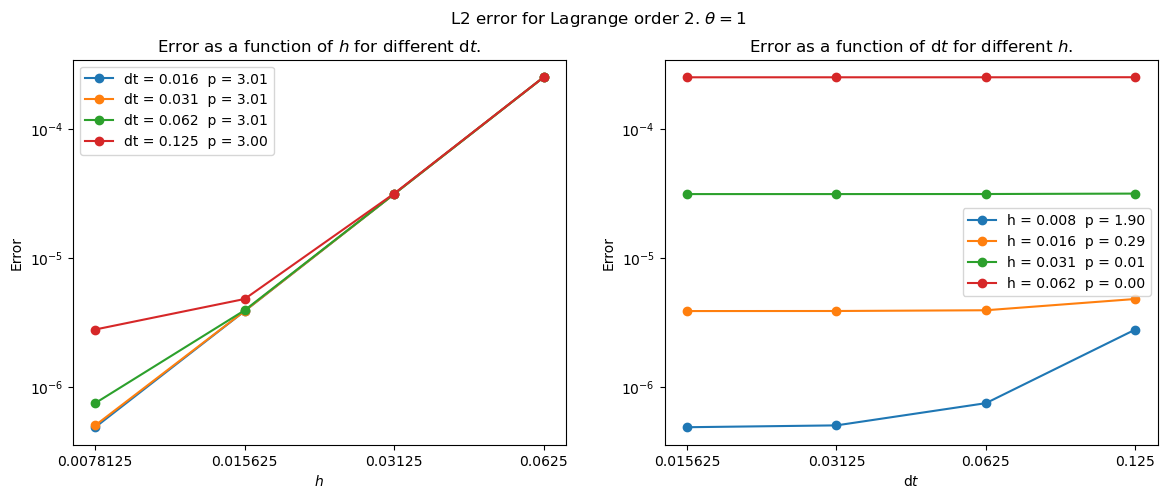

In [31]:
%autoreload
hs = [1/(2**i) for i in range(7, 3, -1)]
dts = [1/(2**i) for i in range(6, 2, -1)]

results.convergence_plot(hs, dts, theta=1, lagrange_order=2, plot_title="dual_convergence.png")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000473791s, CPU 0.000483s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.480432s, CPU 0.471859s)
Info    : 19241 nodes 38484 elements
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000226292s, CPU 0.000298s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.11202s, CPU 0.111552s)
Info    : 4880 nodes 9762 elements
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshin

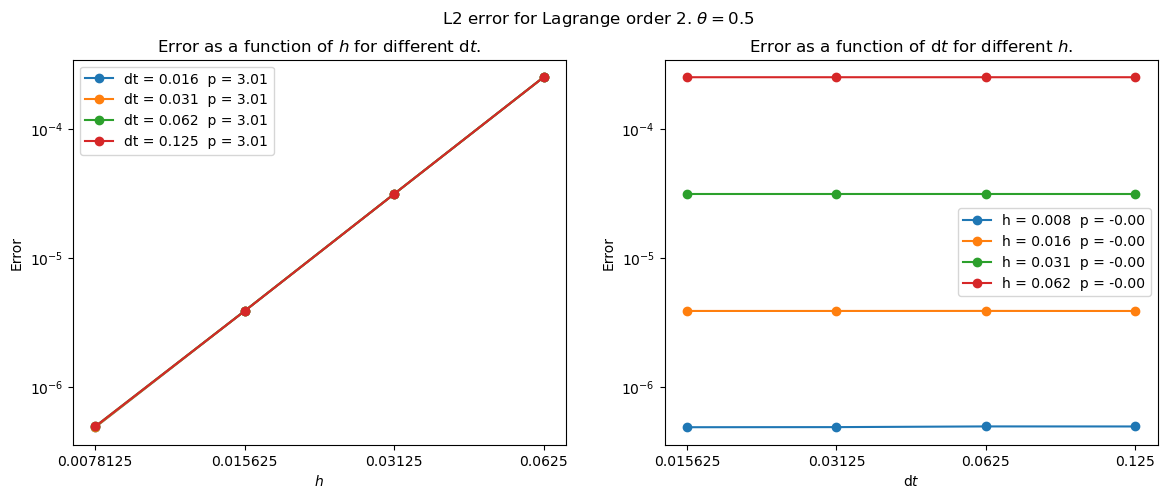

In [32]:
%autoreload
hs = [1/(2**i) for i in range(7, 3, -1)]
dts = [1/(2**i) for i in range(6, 2, -1)]

results.convergence_plot(hs, dts, theta=0.5, lagrange_order=2)

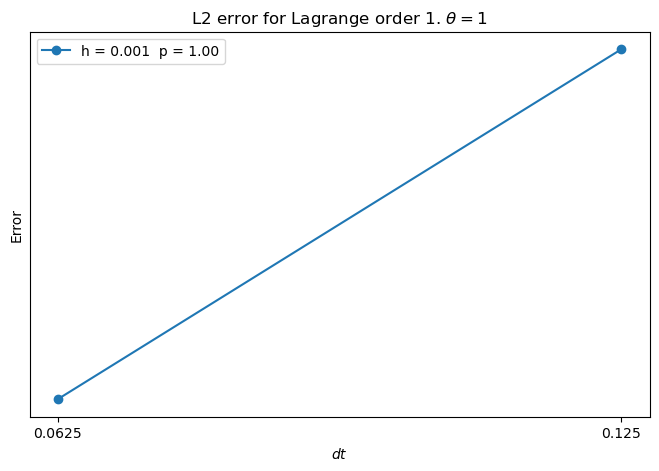

In [15]:
%autoreload
h = 2**(-10)
dts = [2**(-i) for i in range(4, 2, -1)]
results.convergence_plot(h, dts, theta=1, lagrange_order=1)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000579708s, CPU 0.000757s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 11.0153s, CPU 10.8338s)
Info    : 304258 nodes 608518 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000514625s, CPU 0.000573s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 2.12744s, CPU 2.10823s)
Info    : 76371 nodes 152744 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000237542s, CPU 0.000375s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.114174s, CPU 0.113692s)
Info    : 4880 nodes 9762 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000498625s, CPU 0.000587s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 11.0552s, CPU 10.9126s)
Info    : 304258 nodes 608518 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000701959s, CPU 0.000627s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 2.13622s, CPU 2.11381s)
Info    : 76371 nodes 152744 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000216s, CPU 0.000349s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.114008s, CPU 0.113344s)
Info    : 4880 nodes 9762 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000530959s, CPU 0.000577s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 11.0891s, CPU 10.9567s)
Info    : 304258 nodes 608518 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000448833s, CPU 0.000496s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 2.20625s, CPU 2.12629s)
Info    : 76371 nodes 152744 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000210542s, CPU 0.00034s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.114253s, CPU 0.113586s)
Info    : 4880 nodes 9762 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000512791s, CPU 0.000631s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 11.0419s, CPU 10.9283s)
Info    : 304258 nodes 608518 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.0004465s, CPU 0.000533s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 2.14089s, CPU 2.11747s)
Info    : 76371 nodes 152744 elements


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00020475s, CPU 0.000303s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.113787s, CPU 0.113196s)
Info    : 4880 nodes 9762 elements


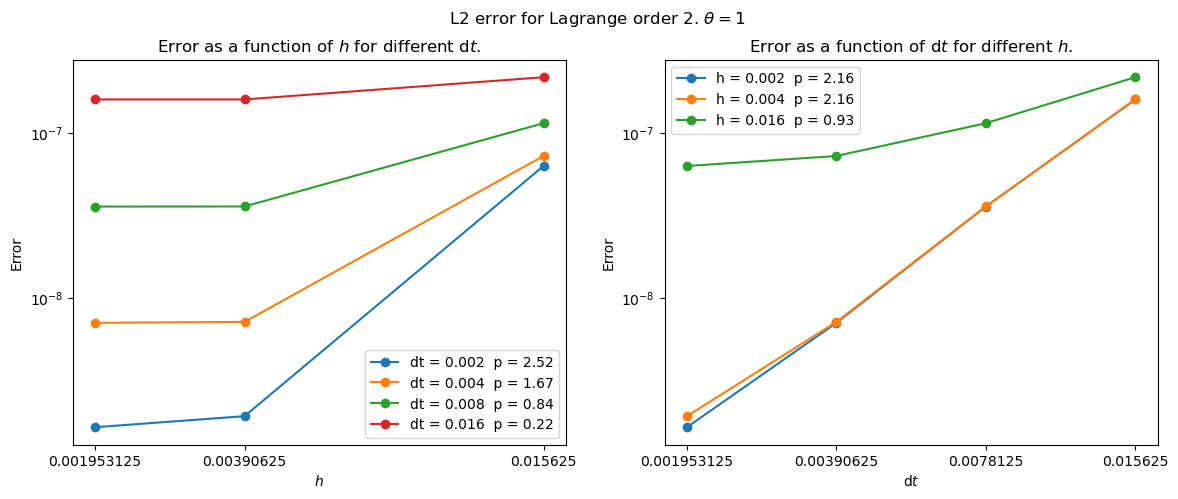

In [6]:
%autoreload
hs = [2**(-9), 2**(-8), 2**(-6)]
dts = [2**(-i) for i in range(9, 5, -1)]
results.convergence_plot(hs, dts, theta=1, T=0.01, lagrange_order=2)

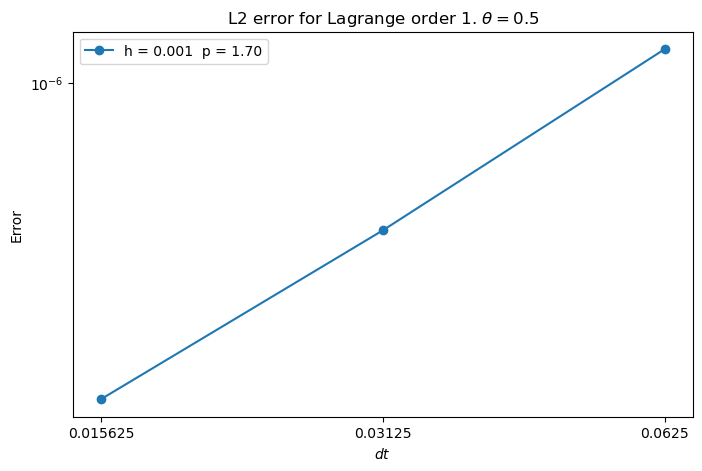

In [2]:
h = 2**(-10)
dts = [2**(-i) for i in range(6, 3, -1)]
results.convergence_plot(h, dts, theta=0.5, lagrange_order=1, T=0.001)